# Numerical solution to the diffusion equation

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Jens aka Snowdog'

In realistic reactor calculations the analytical solution of the transport, or even the diffusion equation is usually not possible (for example due to the heterogenities in the reactor, such as fuel rods, cladding, moderator channels, etc).

We have previously seen how to handle the neutron transport problem with Monte Carlo methods. However, Monte Carlo particle transport does have a very significant flaw: it is time consuming. In practical, industrial applications neutron transport it solved with deterministic methods, and Monte Carlo is usually used as a validational method (although as computers are becoming more powerful, the role of Monte Carlo calculations is getting even more significant). 

Deterministic neutron transport has many parts (from handling slowing down and thermalization to get group constants till performing full core neutron diffusion calculation), and it is outside of the scope of this course. Nevertheless, during this datalab we will look at the basic idea of solving neutron diffusion with numerical methods. For this we will limit ourselves to a very simple case: we will assume that our reactor is a 1-dimensional slab, where all the neutrons are traveling with the same speed (ie. one-group theory), and we will also not bother much with boundary conditions. The intention of the lab is to provide an impression of the deterministic solutions, and not to get lost in details (for readers who would like to go in depth, we can recommend the [Duderstadt & Hamilton book](https://deepblue.lib.umich.edu/handle/2027.42/89079) as a starter, and then the [Computational Nuclear Engineering book of McClarren](https://www.elsevier.com/books/computational-nuclear-engineering-and-radiological-science-using-python/mcclarren/978-0-12-812253-2), and finally for the brave the [Applied Reactor Physics book of Hébert](https://www.polymtl.ca/merlin/downloads/5784_depliant-AppliedReactor_ep3.pdf)). 

We will first solve the neutron diffusion problem for a non multiplying medium (thus $\Sigma_f=0$), and then try to tackle a multiplying medium. The general recipe will be that we try to convert our differential equation into linear algebra. Finally we will make a simplified approach to obtain group cross sections necessary for such numerical methods.

Note that a slab reactor you can imagine as space infinite along $y$ and $z$ directions, but finite in $x$ direction. In such a reactor it does not matter where we are along the $y$ and $z$ axis, therefore we can solve for the flux in 1D.

## Experiment 1 : non multiplying medium


Let's consider that we have a slab geometry, in which a neutron source is placed. In this case we know that we are going to have a steady state flux. We can describe the system as 

$$-D\frac{d^2\phi}{dx^2}+\Sigma_a\phi(x)=S(x)$$

with boundary conditions

$$\phi(0)=\phi(a)=0$$

(let's ignore now the extrapolation length).

We can discretize the spatial variable $x$ by choosing a set of $N+1$ discrete points ($x_0,x_1,...,x_i,...x_N$) which are equally spaced. The distance between the neigbouring points is $\Delta=a/N$.

If we wanted to rewrite the above diffusion equation at each discrete $x_i$ point in the form of difference equations, we need an approximation for the term $\frac{d^2\phi}{dx^2}$. We can Taylor expend $\phi$ at $x_{i\pm1}$:

$$\phi_{i+1}=\phi(x_{i+1})=\phi_i+\Delta\frac{d\phi}{dx}\Big\rvert_i+\frac{\Delta^2}{2}\frac{d^2\phi}{dx^2}\Big\rvert_i+...$$

and

$$\phi_{i-1}=\phi(x_{i-1})=\phi_i-\Delta\frac{d\phi}{dx}\Big\rvert_i+\frac{\Delta^2}{2}\frac{d^2\phi}{dx^2}\Big\rvert_i-...$$

Upon adding these one arrives to

$$\frac{d^2\phi}{dx^2}\Big\rvert_i\approx \frac{\phi_{i+1}-2\phi_i+\phi_{i-1}}{\Delta^2}$$

with that our diffusion equation becomes

$$-D\Bigg(\frac{\phi_{i+1}-2\phi_i+\phi_{i-1}}{\Delta^2}\Bigg)+\Sigma_a\phi_i=S_i \quad i=1,2,...$$

We can rearrange this

$$-\frac{D}{\Delta^2}\phi_{i-1}+\Big(\frac{2D}{\Delta^2}+\Sigma_a\Big)\phi_i-\frac{D}{\Delta^2}\phi_{i+1}=S_i$$

so by introducing constants

$$a_{i,i-1}\phi_{i-1}+a_{i,i}\phi_i-a_{i,i+1}\phi_{i+1}=S_i \quad i=1,2...,N-1$$

(we don't have equations for $i=0$ and $i=N$, since we have boundary conditions there, which actually present themself by the fact that in case of $i=1$ the $\phi_{i-1}$ disappears).

Now, one can see that this is a matrix multiplied with a vector, which results in a vector, in the form of

$$\underline{\underline{A}}\underline{\phi}=\underline{S}$$

where $\underline{\underline{A}}$ is made of the above defined coefficients:

$\begin{equation}
\begin{pmatrix}
a_{1,1} & a_{1,2} & 0 & 0 & 0 & \cdots \\
a_{2,1} & a_{2,2} & a_{2,3} & 0 & 0 & \cdots \\
0 & a_{3,2} & a_{3,3} & a_{3,4} & 0 & \cdots \\
0 & 0 & a_{4,3} & a_{4,4} & a_{4,5} & \cdots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots &
\end{pmatrix}
\end{equation}$

and the vector $\underline{\phi}$ is simply the flux at the discrete locations
$
\begin{equation}
\begin{pmatrix}
\phi_1 \\ \phi_2 \\ \phi_3 \\ \vdots \\ \phi_{N-2} \\ \phi_{N-1}
\end{pmatrix}
\end{equation}
$

this is what we seek as the solution!

And $\underline{S}$ is the source at different locations. 
$
\begin{equation}
\begin{pmatrix}
S_1 \\ S_2 \\ S_3 \\ \vdots \\ S_{N-2} \\ S_{N-1}
\end{pmatrix}
\end{equation}
$

which is an input. For example we could have just a plane source (only one non-zero value).

Thus by inverting the matrix one can solve for the flux. 

$$\underline{\phi}=\underline{\underline{A}}^{-1}\underline{S}$$

The problem could be further developed by assuming that $D$ and $\Sigma_a$ also depend on the spatial coordinate. And the problem is similar in multiple dimensions. However for the current exercise we can consider the simplest case, with constant $D$ and $\Sigma_a$ in a finite one-dimensional geometry.

Once we implement matrix $\underline{\underline{A}}$, we can use numpy's linear algebra module to solve such matrix equations: `flux=np.linalg.solve(A,S)`. So let's do that! Implement the matrix below, then execute the code block!

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def createA(Sigma_a,D,a,N):
    """Function to create matrix A
    
    Parameters
    ----------
    Sigma_a : float
        Macroscopic absorption cross section
    D : float
        Diffusion coefficient
    a : float
        Width of the slab
    N : int
        Number of discrete points
    """
    A=np.zeros((N-1,N-1))
    Delta=a/N
    # create a coefficients
    a1 = (2*D/Delta**2 + Sigma_a)
    a2 = -D/Delta**2
    for i in range(0,N-1):
        A[i,i] = a1
        A[i,i-1] = a2
        if i == 0: # handle first a_{i minus i} entrance. change i=0-1 value to 0, since it becomes last value in first row
            A[i,i-1] = 0.
        if i == N-2: # handle last a_{i plus i} entrance. stop before exceeding last entry
            break
        A[i,i+1] = a2
    return A

And now let's use this. We can first solve for a case when there is a source plane at the center of the slab. Execute the code below.

A matrix:
[[ 0.516 -0.225  0.    ...  0.     0.     0.   ]
 [-0.225  0.516 -0.225 ...  0.     0.     0.   ]
 [ 0.    -0.225  0.516 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.516 -0.225  0.   ]
 [ 0.     0.     0.    ... -0.225  0.516 -0.225]
 [ 0.     0.     0.    ...  0.    -0.225  0.516]]


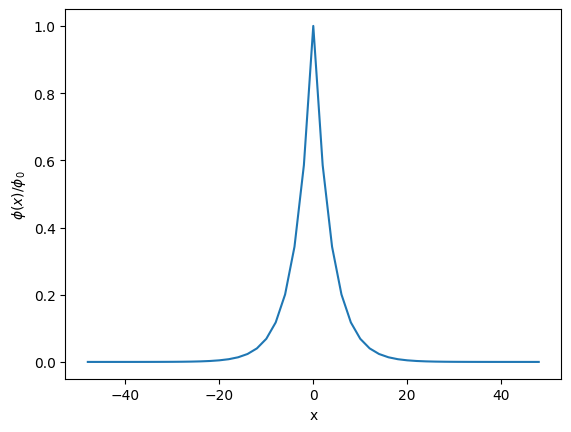

In [71]:
#Input data
a=100
D=0.9
Sigma_a=0.066
N=50

#create matrix A
A=createA(Sigma_a,D,a,N)
print('A matrix:')
print(A)
#create space coordinates
x=np.linspace(-a/2,a/2,N+1)

#Define the source and place a source in the middle
S=np.zeros(N-1)
S[int(N/2-1)]=1000      

#Solve for the flux
flux=np.linalg.solve(A,S)

plt.figure()
plt.plot(x[1:-1],flux/(np.max(flux)))
plt.xlabel('x')
plt.ylabel(r'$\phi(x)/\phi_0$')
plt.show()


Now define a source which is uniform all over the slab. What shape do you expect for the flux?

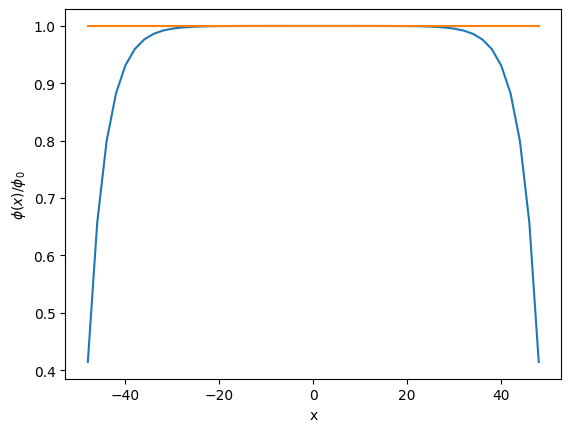

In [76]:
#Define the source and place a source in the middle
S=np.random.uniform(1,1,size=N-1) # weird way to make a list of ones

#Solve for the flux
flux=np.linalg.solve(A,S)

plt.figure()
plt.plot(x[1:-1],flux/(np.max(flux)))
plt.plot(x[1:-1],S)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)/\phi_0$')
plt.show()

Let's see what happens when the absorption cross section is lowered in case of a planar source. Try to lower it in several steps with 10%, 1% and 0.1% of the original value, what is your expectation, and what have you found? Conclude your results!

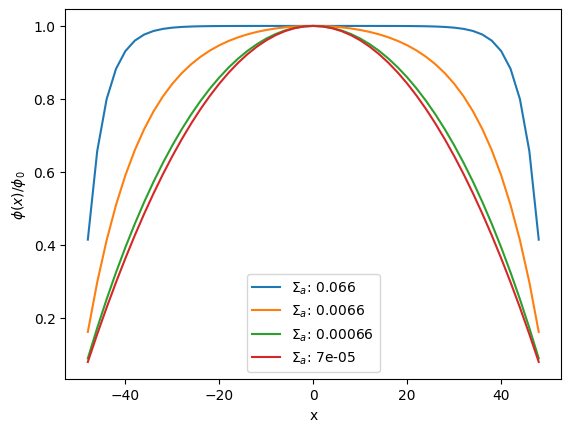

In [77]:
#Input data
a=100
D=0.9
factor = np.array([1,1e-1,1e-2,1e-3])
Sigma_as=0.066*factor
N=50

#create space coordinates
x=np.linspace(-a/2,a/2,N+1)

#Define the source and place a source in the middle
S=np.random.uniform(1,1,size=N-1) # weird way to make a list of ones

plt.figure()
for Sigma_a in Sigma_as:
    A=createA(Sigma_a,D,a,N)
    flux=np.linalg.solve(A,S)
    plt.plot(x[1:-1],flux/(np.max(flux)),label=f'$\Sigma_a$: {round(Sigma_a,5)}')
plt.xlabel('x')
plt.ylabel(r'$\phi(x)/\phi_0$')
plt.legend()
plt.show()

With a small absorption crosssection, the a coefficients $\approx a_{i,i} = a_{i,i-1} + a_{i,i+1}$

The flux falls off faster with smaller absorption cross section?

## Experiment 2 : multiplying medium (k-eigenvalue problem)

Now let's consider that the system does not have an external source, however it is built of multiplying medium. In this case the equation is slightly different, since instead of a fixed source, we have now a fission source:

$$-D\frac{d^2\phi}{dx^2}+\Sigma_a\phi(x)=\frac{\nu}{k}\Sigma_f\phi(x)$$

where we renormalized the fission source with the k-eigenvalue. The reason for this is because we would like to obtain a steady state equation. However, if a system is supercritical, the neutron population increases in time, therefore the normalization with $k>1$ will reduce the neutron production term due to fission. Whereas, for a subcritical system, when the neutron population in reality decreases, normalizing with $k<1$ will increase the number of neutrons produced in fission to the level when the system is at steady state. 

After similar considerations as before for the non-multiplying system, we can arrive to the discretized form

$$-\frac{D}{\Delta^2}\phi_{i-1}+\Big(\frac{2D}{\Delta^2}+\Sigma_a\Big)\phi_i-\frac{D}{\Delta^2}\phi_{i+1}=\frac{\nu}{k}\Sigma_f\phi_i$$

which we can write as an eigenvalue problem:

$$\underline{\underline{A}}\underline{\phi}=\frac{1}{k}\underline{\underline{B}}\underline{\phi}$$

where $\underline{\underline{A}}$ is as defined before, and $\underline{\underline{B}}$ is:

\begin{equation}
\begin{pmatrix}
\nu\Sigma_f & 0 & 0 & 0 & 0 & \cdots \\
0 & \nu\Sigma_f & 0 & 0 & 0 & \cdots \\
0 & 0 & \nu\Sigma_f & 0 & 0 & \cdots \\
0 & 0 & 0 & \nu\Sigma_f & 0 & \cdots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots &
\end{pmatrix}
\end{equation}

We can arrange this into a standard eigenvalue problem

$$\underline{\underline{A}}^{-1}\underline{\underline{B}}\underline{\phi}=\underline{\underline{C}}\underline{\phi}=k\underline{\phi}$$

For which the largest eigenvalue will be the k-effective. Such problems can be solved with the [inverse power method](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter15.02-The-Power-Method.html) (also detailed in the previously mentioned McClaren book). The idea is that 

1. We take a random guess of $\underline{\phi}^{(0)}$ (where the upper index is the iteration number)
2. Perform $\underline{\underline{C}}\underline{\phi}^{(0)}$ to obtain $\underline{\phi}^{(1)}$
3. Normalize $\underline{\phi}^{(1)}$ to get an estimate of $k$
4. We repeat 1-4 until $k$ converged.

We have implemented the inverse power algorithm in function `invPow()`. You will only need to create matrix $\underline{\underline{B}}$ and run the code!

**Note** within function `invPow()` we use `np.linalg.inv()` to invert the matrix and `@` stands for matrix multiplication. And `np.dot()` performs the dot product of the matrix and the vector.

In [ ]:
def createB(nuSigma_f,N):
    """Function to create matrix B
    
    Parameters
    ----------
    nuSigma_f : float
        nu*Sigma_f fission source
    N : int
        Number of discrete points
    """
    B=np.zeros((N-1,N-1))
    for i in range(1,N):
        #complete the function
    return B

def invPow(A,B,tol=1e-6):
    phi=np.random.random((A.shape[0])) #initial guess
    C=np.linalg.inv(A) @ B
    converged = False
    kold=0.0
    while not converged:
        phi = np.dot(C,phi)
        k = np.max(np.abs(phi))
        phi = phi / np.max(phi)
        if abs(kold-k)<tol:
            converged = True
        kold=k
    return k, phi

Now let's try this with some values. What is your expectation for the flux shape?

In [ ]:
a=100
D=3.85
Sigma_a=0.1532
nuSigma_f=0.157
N=50
x=np.linspace(-a/2,a/2,N+1)

#create matrix A
#create matrix B
k,phi=invPow(A,B)

print(k)
plt.figure()
plt.plot(x[1:-1],phi)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)/\phi_0$')
plt.show()

Note that with little work you can modify the `invPow()` to see how the flux shape converges during the iteration. If you are interested, feel free to add that.

What happens if we put a control rod into the reactor? Think, what modifications do you need to do to represent a control rod? (Hint: you do not need to modify `createA()` or `createB()` for this, it is enough to modify one or more elements of the already created matrices Note: you might experience an assymetric flux shape even if you modified the material properties in the center of the reactor. It might be possible that your flux profile has not converged yet. Also, since the initial guess of the flux shape is random, there is some randomness in the iterations. That said, if you run the code cell multiple times, you might experience that sometimes with less iterations you get a better result).

In [ ]:
#write your code here!

# Experiment 3

In the previous exercises we relied on 1-group cross sections which were given in the exercise. However in practice in order to perform a diffusion calculation (either 1 or multi-group) we first need to obtain the group cross sections. 

The group cross sections are the spectrum weighted averages of the continuous cross sections (where, for this homogeneous case we could consider that the material is a mixture of nuclides, eg. uranium nuclides and water nuclides, therefore first we would get the weighted cross sections of the nuclides and then determine the cross sections for the mixture.):

$$\sigma_g=\frac{\int_{E_{g}}^{E_{g-1}}\sigma(E)\Phi(E)dE}{\int_{E_{g}}^{E_{g-1}}\Phi(E)dE}$$

Where $g$ stands for the group. In case of a one-group approximation the integral is performed from $0$ to $\infty$ (or some appropriate lower and upper energy bounds). Also remember that due to neutrons slowing down in energy, the group labeling goes in a reversed order (see lecture notes).

Note that the energy dependent flux needs to be a priori known for calculating the group cross sections. That is one of the reasons why determinstic methods solve the transport problem in multiple steps. First on a cell level we try to obtain the group cross sections, and then perform a full core calculation based on the group cross sections. Today a common method is to generate group constants from Monte Carlo methods (which is feasible at the assembly level), and then use them in fast deterministic calculations.

Now we will evaluate the above integration to obtain the 1 group fission cross section of U-235. In the following code block we load in some data:

- `energy` and `xs` will store the continious energy fission cross section of U-235.
- `enlow`, `enhigh` and `flux` store the information on the neutron spectrum which we obtained from a separate openMC calculation (this is the type of data we have tallied during the previous datalab).

Let's load it, and see what we can do with them. (Note that as in Datalab 3, if you have difficulties downloading the cross section data from the KAERI site, you can try to access my homepage instead, where I have uploaded the same html file: just uncomment the `website='https://ezsolti.github.io/rfpxsdata/target=jeff3.2,92,235,9228,3,18'` line)

In [ ]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'
#website='https://ezsolti.github.io/rfpxsdata/target=jeff3.2,92,235,9228,3,18'

with urllib.request.urlopen(website) as response:
    content235 = response.readlines()
    
def getXS(content):
    """Function to extract data from the html content provided by KAERI.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  len(x)>0 and x[0]==b'Energy(eV)':
            flag=True
            continue
        if len(x)==0 or x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

energy,xs=getXS(content235)

enlow=np.array([1.00000000e-02, 1.10917482e-02, 1.23026877e-02, 1.36458314e-02,
       1.51356125e-02, 1.67880402e-02, 1.86208714e-02, 2.06538016e-02,
       2.29086765e-02, 2.54097271e-02, 2.81838293e-02, 3.12607937e-02,
       3.46736850e-02, 3.84591782e-02, 4.26579519e-02, 4.73151259e-02,
       5.24807460e-02, 5.82103218e-02, 6.45654229e-02, 7.16143410e-02,
       7.94328235e-02, 8.81048873e-02, 9.77237221e-02, 1.08392691e-01,
       1.20226443e-01, 1.33352143e-01, 1.47910839e-01, 1.64058977e-01,
       1.81970086e-01, 2.01836636e-01, 2.23872114e-01, 2.48313311e-01,
       2.75422870e-01, 3.05492111e-01, 3.38844156e-01, 3.75837404e-01,
       4.16869383e-01, 4.62381021e-01, 5.12861384e-01, 5.68852931e-01,
       6.30957344e-01, 6.99841996e-01, 7.76247117e-01, 8.60993752e-01,
       9.54992586e-01, 1.05925373e+00, 1.17489755e+00, 1.30316678e+00,
       1.44543977e+00, 1.60324539e+00, 1.77827941e+00, 1.97242274e+00,
       2.18776162e+00, 2.42661010e+00, 2.69153480e+00, 2.98538262e+00,
       3.31131121e+00, 3.67282300e+00, 4.07380278e+00, 4.51855944e+00,
       5.01187234e+00, 5.55904257e+00, 6.16595002e+00, 6.83911647e+00,
       7.58577575e+00, 8.41395142e+00, 9.33254301e+00, 1.03514217e+01,
       1.14815362e+01, 1.27350308e+01, 1.41253754e+01, 1.56675107e+01,
       1.73780083e+01, 1.92752491e+01, 2.13796209e+01, 2.37137371e+01,
       2.63026799e+01, 2.91742701e+01, 3.23593657e+01, 3.58921935e+01,
       3.98107171e+01, 4.41570447e+01, 4.89778819e+01, 5.43250331e+01,
       6.02559586e+01, 6.68343918e+01, 7.41310241e+01, 8.22242650e+01,
       9.12010839e+01, 1.01157945e+02, 1.12201845e+02, 1.24451461e+02,
       1.38038426e+02, 1.53108746e+02, 1.69824365e+02, 1.88364909e+02,
       2.08929613e+02, 2.31739465e+02, 2.57039578e+02, 2.85101827e+02,
       3.16227766e+02, 3.50751874e+02, 3.89045145e+02, 4.31519077e+02,
       4.78630092e+02, 5.30884444e+02, 5.88843655e+02, 6.53130553e+02,
       7.24435960e+02, 8.03526122e+02, 8.91250938e+02, 9.88553095e+02,
       1.09647820e+03, 1.21618600e+03, 1.34896288e+03, 1.49623566e+03,
       1.65958691e+03, 1.84077200e+03, 2.04173794e+03, 2.26464431e+03,
       2.51188643e+03, 2.78612117e+03, 3.09029543e+03, 3.42767787e+03,
       3.80189396e+03, 4.21696503e+03, 4.67735141e+03, 5.18800039e+03,
       5.75439937e+03, 6.38263486e+03, 7.07945784e+03, 7.85235635e+03,
       8.70963590e+03, 9.66050879e+03, 1.07151931e+04, 1.18850223e+04,
       1.31825674e+04, 1.46217717e+04, 1.62181010e+04, 1.79887092e+04,
       1.99526231e+04, 2.21309471e+04, 2.45470892e+04, 2.72270131e+04,
       3.01995172e+04, 3.34965439e+04, 3.71535229e+04, 4.12097519e+04,
       4.57088190e+04, 5.06990708e+04, 5.62341325e+04, 6.23734835e+04,
       6.91830971e+04, 7.67361489e+04, 8.51138038e+04, 9.44060876e+04,
       1.04712855e+05, 1.16144861e+05, 1.28824955e+05, 1.42889396e+05,
       1.58489319e+05, 1.75792361e+05, 1.94984460e+05, 2.16271852e+05,
       2.39883292e+05, 2.66072506e+05, 2.95120923e+05, 3.27340695e+05,
       3.63078055e+05, 4.02717034e+05, 4.46683592e+05, 4.95450191e+05,
       5.49540874e+05, 6.09536897e+05, 6.76082975e+05, 7.49894209e+05,
       8.31763771e+05, 9.22571427e+05, 1.02329299e+06, 1.13501082e+06,
       1.25892541e+06, 1.39636836e+06, 1.54881662e+06, 1.71790839e+06,
       1.90546072e+06, 2.11348904e+06, 2.34422882e+06, 2.60015956e+06,
       2.88403150e+06, 3.19889511e+06, 3.54813389e+06, 3.93550075e+06,
       4.36515832e+06, 4.84172368e+06, 5.37031796e+06, 5.95662144e+06,
       6.60693448e+06, 7.32824533e+06, 8.12830516e+06, 9.01571138e+06])

enhigh=np.array([1.10917482e-02, 1.23026877e-02, 1.36458314e-02, 1.51356125e-02,
       1.67880402e-02, 1.86208714e-02, 2.06538016e-02, 2.29086765e-02,
       2.54097271e-02, 2.81838293e-02, 3.12607937e-02, 3.46736850e-02,
       3.84591782e-02, 4.26579519e-02, 4.73151259e-02, 5.24807460e-02,
       5.82103218e-02, 6.45654229e-02, 7.16143410e-02, 7.94328235e-02,
       8.81048873e-02, 9.77237221e-02, 1.08392691e-01, 1.20226443e-01,
       1.33352143e-01, 1.47910839e-01, 1.64058977e-01, 1.81970086e-01,
       2.01836636e-01, 2.23872114e-01, 2.48313311e-01, 2.75422870e-01,
       3.05492111e-01, 3.38844156e-01, 3.75837404e-01, 4.16869383e-01,
       4.62381021e-01, 5.12861384e-01, 5.68852931e-01, 6.30957344e-01,
       6.99841996e-01, 7.76247117e-01, 8.60993752e-01, 9.54992586e-01,
       1.05925373e+00, 1.17489755e+00, 1.30316678e+00, 1.44543977e+00,
       1.60324539e+00, 1.77827941e+00, 1.97242274e+00, 2.18776162e+00,
       2.42661010e+00, 2.69153480e+00, 2.98538262e+00, 3.31131121e+00,
       3.67282300e+00, 4.07380278e+00, 4.51855944e+00, 5.01187234e+00,
       5.55904257e+00, 6.16595002e+00, 6.83911647e+00, 7.58577575e+00,
       8.41395142e+00, 9.33254301e+00, 1.03514217e+01, 1.14815362e+01,
       1.27350308e+01, 1.41253754e+01, 1.56675107e+01, 1.73780083e+01,
       1.92752491e+01, 2.13796209e+01, 2.37137371e+01, 2.63026799e+01,
       2.91742701e+01, 3.23593657e+01, 3.58921935e+01, 3.98107171e+01,
       4.41570447e+01, 4.89778819e+01, 5.43250331e+01, 6.02559586e+01,
       6.68343918e+01, 7.41310241e+01, 8.22242650e+01, 9.12010839e+01,
       1.01157945e+02, 1.12201845e+02, 1.24451461e+02, 1.38038426e+02,
       1.53108746e+02, 1.69824365e+02, 1.88364909e+02, 2.08929613e+02,
       2.31739465e+02, 2.57039578e+02, 2.85101827e+02, 3.16227766e+02,
       3.50751874e+02, 3.89045145e+02, 4.31519077e+02, 4.78630092e+02,
       5.30884444e+02, 5.88843655e+02, 6.53130553e+02, 7.24435960e+02,
       8.03526122e+02, 8.91250938e+02, 9.88553095e+02, 1.09647820e+03,
       1.21618600e+03, 1.34896288e+03, 1.49623566e+03, 1.65958691e+03,
       1.84077200e+03, 2.04173794e+03, 2.26464431e+03, 2.51188643e+03,
       2.78612117e+03, 3.09029543e+03, 3.42767787e+03, 3.80189396e+03,
       4.21696503e+03, 4.67735141e+03, 5.18800039e+03, 5.75439937e+03,
       6.38263486e+03, 7.07945784e+03, 7.85235635e+03, 8.70963590e+03,
       9.66050879e+03, 1.07151931e+04, 1.18850223e+04, 1.31825674e+04,
       1.46217717e+04, 1.62181010e+04, 1.79887092e+04, 1.99526231e+04,
       2.21309471e+04, 2.45470892e+04, 2.72270131e+04, 3.01995172e+04,
       3.34965439e+04, 3.71535229e+04, 4.12097519e+04, 4.57088190e+04,
       5.06990708e+04, 5.62341325e+04, 6.23734835e+04, 6.91830971e+04,
       7.67361489e+04, 8.51138038e+04, 9.44060876e+04, 1.04712855e+05,
       1.16144861e+05, 1.28824955e+05, 1.42889396e+05, 1.58489319e+05,
       1.75792361e+05, 1.94984460e+05, 2.16271852e+05, 2.39883292e+05,
       2.66072506e+05, 2.95120923e+05, 3.27340695e+05, 3.63078055e+05,
       4.02717034e+05, 4.46683592e+05, 4.95450191e+05, 5.49540874e+05,
       6.09536897e+05, 6.76082975e+05, 7.49894209e+05, 8.31763771e+05,
       9.22571427e+05, 1.02329299e+06, 1.13501082e+06, 1.25892541e+06,
       1.39636836e+06, 1.54881662e+06, 1.71790839e+06, 1.90546072e+06,
       2.11348904e+06, 2.34422882e+06, 2.60015956e+06, 2.88403150e+06,
       3.19889511e+06, 3.54813389e+06, 3.93550075e+06, 4.36515832e+06,
       4.84172368e+06, 5.37031796e+06, 5.95662144e+06, 6.60693448e+06,
       7.32824533e+06, 8.12830516e+06, 9.01571138e+06, 1.00000000e+07])

flux=np.array([0.02577856, 0.03066058, 0.03603053, 0.04240431, 0.05002994,
       0.05839512, 0.06726075, 0.0774172 , 0.08861314, 0.10032227,
       0.11204404, 0.1241643 , 0.13569794, 0.14679644, 0.15612227,
       0.163737  , 0.1679735 , 0.16947752, 0.16634144, 0.16142205,
       0.15277212, 0.14084592, 0.12866013, 0.11470102, 0.10077805,
       0.08728958, 0.07620083, 0.06686899, 0.0595781 , 0.05401424,
       0.0500681 , 0.04688048, 0.04562412, 0.04461072, 0.04429055,
       0.04411934, 0.04360341, 0.04294853, 0.04230007, 0.04170813,
       0.04151998, 0.04102959, 0.04036848, 0.03990512, 0.03981038,
       0.03873371, 0.0388913 , 0.03930658, 0.03864539, 0.03847107,
       0.03782591, 0.03827199, 0.03778458, 0.0375978 , 0.03731462,
       0.03743993, 0.03766099, 0.03748085, 0.03692993, 0.03679025,
       0.03594861, 0.03429717, 0.01577556, 0.03367109, 0.03985187,
       0.04026397, 0.04114586, 0.04139404, 0.04003358, 0.04117315,
       0.04142176, 0.04097295, 0.04057454, 0.02738534, 0.04108266,
       0.04348966, 0.04373484, 0.04306126, 0.04201883, 0.03272645,
       0.04509743, 0.04554253, 0.04547996, 0.04555959, 0.04138011,
       0.04519736, 0.04433602, 0.04654428, 0.04765958, 0.04234967,
       0.0454248 , 0.04665341, 0.04755707, 0.04616193, 0.05216002,
       0.04278341, 0.04762769, 0.04762244, 0.04718167, 0.04804163,
       0.04886103, 0.04887618, 0.04842858, 0.04834029, 0.04909005,
       0.04867371, 0.04908572, 0.04886949, 0.04949842, 0.04942243,
       0.05127609, 0.04863334, 0.0495057 , 0.0499865 , 0.05046035,
       0.05118903, 0.04976062, 0.05068816, 0.05117331, 0.05018697,
       0.05132272, 0.05110207, 0.05182998, 0.0513591 , 0.05255648,
       0.05254036, 0.05264878, 0.05271078, 0.0528482 , 0.0533772 ,
       0.05363962, 0.05414106, 0.05401488, 0.05520938, 0.05584227,
       0.05598427, 0.05620829, 0.05657112, 0.05761279, 0.05755317,
       0.05936508, 0.06002431, 0.06015312, 0.06145382, 0.06266386,
       0.06410618, 0.06537679, 0.06627329, 0.06798494, 0.06997738,
       0.07110513, 0.07421602, 0.07665185, 0.07888876, 0.08224286,
       0.08476568, 0.08807564, 0.09017473, 0.09477286, 0.09989802,
       0.10462593, 0.11046211, 0.1163072 , 0.12171737, 0.12945136,
       0.13813527, 0.15085467, 0.15762304, 0.14900812, 0.133717  ,
       0.15720701, 0.18154412, 0.19507056, 0.20602718, 0.21957512,
       0.24308601, 0.22094504, 0.18701514, 0.19871816, 0.22715274,
       0.21390225, 0.22701861, 0.22410287, 0.22002921, 0.21619758,
       0.23041776, 0.23530943, 0.22175108, 0.20061146, 0.16351667,
       0.1452543 , 0.13621642, 0.1142683 , 0.0940825 , 0.0703381 ,
       0.05378389, 0.03569159, 0.02324831, 0.01404995, 0.00785918])

The spectrum is now integrated over energy bins, and it contains 200 energy bins. If you execute the following code block you can plot it.

In [ ]:
plt.figure()
plt.loglog((enlow+enhigh)/2,flux)
plt.xlabel('Energy (eV)')
plt.ylabel('Group flux per source particle')
plt.show()

Therefore you will need to

- calculate the midpoints of the energybins
- divide the integral spectrum with the length of the bins
- interpolate the continuous cross section at the energy midpoints (you can use the `np.interp()` function)
- calculate the one group cross section by weighting the continuous cross section with the spectrum. You can use the `np.trapz()` function for the integration.

Your final result will be in barn units. If you needed macroscopic group cross sections, you have to multiply with the number density of the nuclide. If you would then multiply with the total flux (for this, one needs to know the power of the reactor), you would obtain the fission rate in U-235.

In [ ]:
energyC=#complete the line to calculate the midpoint energies
fluxpE=#complete the line to calculate the spectrum

plt.figure()
#plot the spectrum
plt.show()
        
xs5interp=#interpolate the continous cross sections at the values of energyC

xs51g=#calculate the 1group cross section
print('1G xs: {:.2f}'.format(xs51g))


# Experiment 4 (optional)

As mentioned before, it is possible to use Monte Carlo codes to obtain group cross sections. One needs to realize that evaluating group constants is not that different than using tallies with the right *scores* and *filters*. In fact openMC has a multi-group cross section module called `openmc.mgxs`.

In the separate '7b-openmc_mgxs.ipynb' notebook you can find a demonstration for a simple slab reactor on how to use openMC for group cross section generation.